In [1]:
import numpy as np
from scipy.ndimage import gaussian_filter, convolve1d
from scipy.signal import convolve2d, convolve
import matplotlib.pyplot as plt
import seaborn as sns

from matplotlib import animation
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.animation as manimation

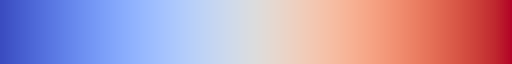

In [2]:
sns.set_palette('coolwarm')
sns.color_palette('coolwarm', as_cmap=True)

In [3]:
# test with image as input 
inp_shape =(100,100)
inp = np.zeros(inp_shape)
inp[50,50] = 1


# params 
sigma_c = 2.5
sigma_s = 7.5

tau = 0.1

In [4]:
def RF_spatial(inp, sigma_c, sigma_s):
    out_c = gaussian_filter(inp, sigma_c)
    out_s = gaussian_filter(inp, sigma_s)
    out_total = out_c - out_s
    
    return out_total


In [5]:
# simulate output of spatial convolution  
out_c = gaussian_filter(inp, sigma_c)
out_s = gaussian_filter(inp, sigma_s)
out_total = out_c - out_s

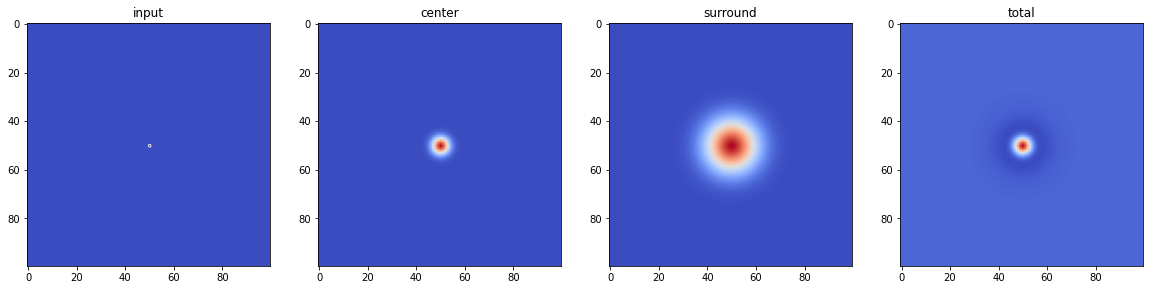

In [6]:
%matplotlib inline
fig,ax = plt.subplots(1,4, figsize = (20,80))
ax[0].imshow(inp, cmap = 'coolwarm')
ax[1].imshow(out_c, cmap = 'coolwarm')
ax[2].imshow(out_s, cmap = 'coolwarm')
ax[3].imshow(out_total, cmap = 'coolwarm')

ax[0].set_title('input')
ax[1].set_title('center')
ax[2].set_title('surround')
ax[3].set_title('total')

plt.show()


center pos = 50
center RF size = 10.0
surround RF size = 30.0


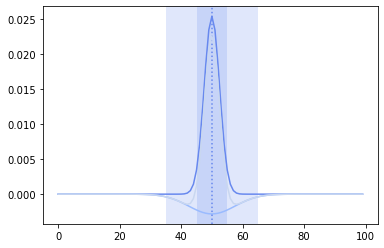

In [7]:
# visualize spatial profile along one axis

def gaussian(x,sigma,pos):
    return np.exp(-(x-pos)**2/(2*sigma**2))/(2*np.pi*sigma**2)

x = np.arange(0,100,1)

sigma_center = 2.5
sigma_surround = 7.5
pos = 50

plt.figure()
plt.plot(x,gaussian(x,sigma_c,pos))
plt.plot(x,-1*gaussian(x,sigma_s,pos))
plt.axvline(pos, linestyle = ':')
plt.axvspan(pos-sigma_c*2, pos+sigma_c*2, alpha = 0.2)
plt.axvspan(pos-sigma_s*2, pos+sigma_s*2, alpha = 0.2)

DOG = gaussian(x, sigma_c, pos)- gaussian(x,sigma_s,pos)
plt.plot(x,DOG)


print(f'center pos = {pos}')
print(f'center RF size = {sigma_center*4}')
print(f'surround RF size = {sigma_surround*4}')

In [8]:
# take video as input, flashing dot
nb_frames = 1000
dt_input = 0.01
video = np.zeros((*inp_shape,nb_frames))


dot_size = 3

x_positions = [11,55,88]

f_starttimes = [100,400,700]
f_stoptimes = [200,500,800]


f_start = 40
f_stop = 50
for f in range(nb_frames):
    
    for i,st in enumerate(f_starttimes):
        if f>=st and f<f_stoptimes[i]:
            start = x_positions[i]-dot_size
            stop = x_positions[i]+dot_size
            video[50-dot_size:50+dot_size,start:stop,f] = 1

In [9]:
# convolve each image with the kernel 
out_spatial = np.zeros((*inp_shape,nb_frames))
#out_vid_manual = np.zeros((*inp_shape,nb_frames))



for f in range(nb_frames):
    out_spatial[:,:,f] = RF_spatial(video[:,:,f], sigma_c, sigma_s)
    #out_vid_manual[:,:,f] = convolve2d(video[:,:,f], out_total_manual, mode='same', boundary='fill', fillvalue=0)
      


Text(0.5, 1.0, 'output scipy')

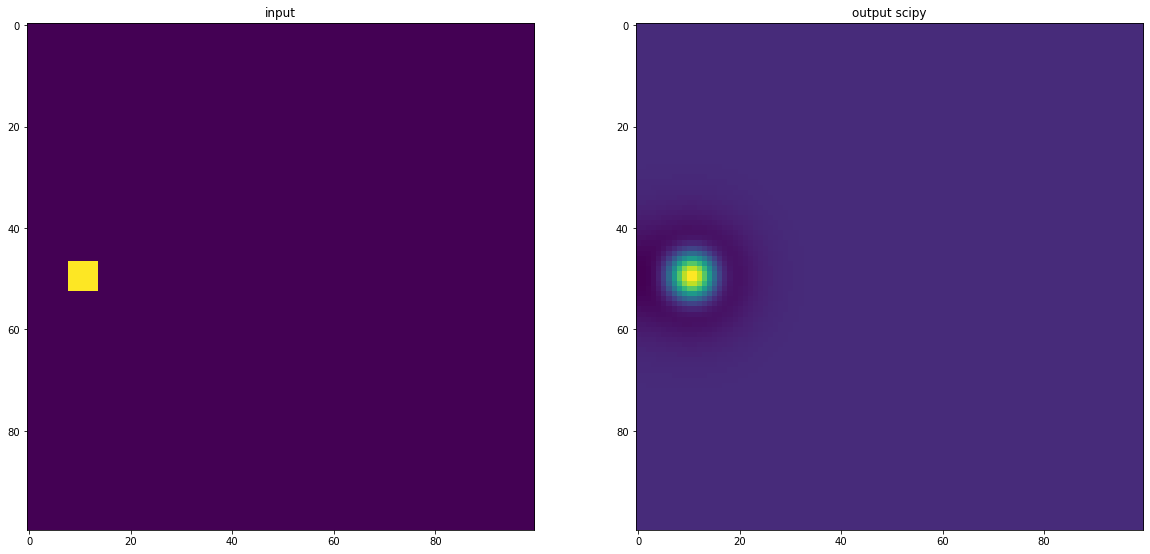

In [10]:
fig,ax = plt.subplots(1,2, figsize = (20,80))
ax[0].imshow(video[:,:,100])
ax[1].imshow(out_spatial[:,:,100])
#ax[2].imshow(out_vid_manual[:,:,11])

ax[0].set_title('input')
ax[1].set_title('output scipy')
#ax[2].set_title('output manual')

In [11]:
# define cells positions that recieve the convolution as current input
# pixel above the pos


nb_cells = 10
xpos = np.linspace(0,inp_shape[0]-1,nb_cells).astype(int)
ypos = 50


In [12]:
xpos

array([ 0, 11, 22, 33, 44, 55, 66, 77, 88, 99])

In [13]:
current_inp = np.zeros((nb_cells,nb_frames))

for c in range(nb_cells):
    for t in range(nb_frames):
        val =  out_spatial[ypos,xpos[c],t]
        current_inp[c,t] = val

(-0.06, 0.5)

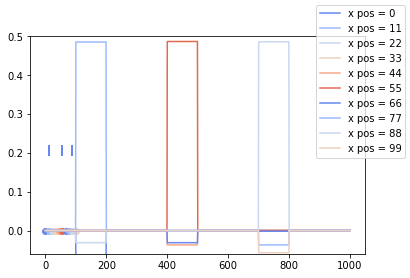

In [14]:
# visualize current input
fig, ax =plt.subplots(1,1)
for c in range(nb_cells):
    plt.plot(current_inp[c,:], label =f'x pos = {xpos[c]}')
    plt.scatter(xpos[c],0)
    
ax.axvspan(x_positions[0]-dot_size,x_positions[0]+dot_size,0.45,0.5)
ax.axvspan(x_positions[1]-dot_size,x_positions[1]+dot_size,0.45,0.5)
ax.axvspan(x_positions[2]-dot_size,x_positions[2]+dot_size,0.45,0.5)


fig.legend()
plt.ylim(-0.06,.5)

# add temporal kernel

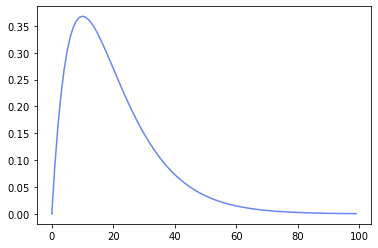

In [15]:
# add temporal kernel
def temp_kernel(t, tau):
    #return np.exp(-t/tau)
    return  (t/tau) * np.exp(-t/tau) * np.heaviside(t,1) 


dt = 0.01
time = 1
t = np.arange(0,time,dt)

temporal_kernel = temp_kernel(t,tau)
plt.plot(temporal_kernel)

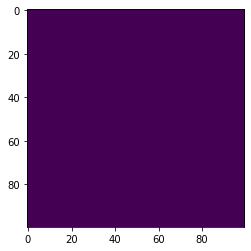

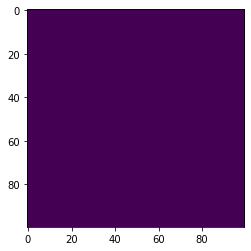

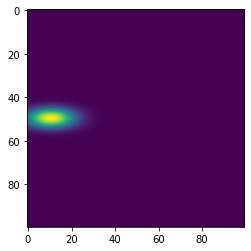

In [16]:
center_kernel = gaussian(x,sigma_center,pos)
surround_kernel = gaussian(x,sigma_surround,pos)
temporal_kernel = temp_kernel(t,tau)


# Convolve over all three axes in a for loop
out_spatiotemporal = video.copy()
for i, k in enumerate([center_kernel, surround_kernel, temporal_kernel]):
    out_spatiotemporal = convolve1d(out_spatiotemporal,k,
                                   axis=i, mode = 'nearest')
    plt.figure()
    plt.imshow(out_spatiotemporal[:,:,90])


In [17]:
out_spatiotemporal.shape

(100, 100, 1000)

In [18]:

for i in range(1000):
    
    t= i*dt*1000
    fig = plt.figure(figsize = (60,20))

    ax = fig.add_subplot(131)
    ax.imshow(video[:,:,i], cmap = 'coolwarm')
    ax.set_title(f" in, t = {t} ms")

    ax2 = fig.add_subplot(132)
    ax2.imshow(out_spatial[:,:,i], cmap = 'coolwarm')
    ax2.set_title(f" out spatial, t = {t} ms")
    
    ax2 = fig.add_subplot(133)
    ax2.imshow(out_spatiotemporal[:,:,i], cmap = 'coolwarm')
    ax2.set_title(f" out spatiotemporal, t = {t} ms ")
    
    
    fig.savefig(f'output_LN_network/flashed_dots_convolution/t_{t}_ms.jpg')

    plt.close()


In [19]:
# make 3D kernel 
def gaussian_3D(x,y,t,sigma,tau,pos):
    
    x,y,t = np.meshgrid(x,y,t)
    
    return np.exp(-((x-pos)**2 + (y-pos)**2)/(2*sigma**2))/(2*np.pi*sigma**2)

#x,y,t = np.meshgrid(x,x,t)


# Manual Gaussian RF desgin 

In [20]:
def gaussian_2D(x,sigma,pos):
    
    x,y = np.meshgrid(x,x)
    
    return np.exp(-((x-pos)**2 + (y-pos)**2)/(2*sigma**2))/(2*np.pi*sigma**2)

def DOG_2D(x,sigma_center,surround,pos):
    
    x,y = np.meshgrid(x,x)
    
    return np.exp(-((x-pos)**2 + (y-pos)**2)/(2*sigma_center**2))/(2*np.pi*sigma_center**2) - np.exp(-((x-pos)**2 + (y-pos)**2)/(2*sigma_surround**2))/(2*np.pi*sigma_surround**2)


out_c_manual = gaussian_2D(x,sigma_center, pos)
out_s_manual = gaussian_2D(x,sigma_surround, pos)
out_total_manual = out_c_manual - out_s_manual

In [25]:
fig,ax = plt.subplots(1,4, figsize = (20,80))
ax[0].imshow(inp)
ax[1].imshow(out_c_manual)
ax[2].imshow(out_s_manual)
ax[3].imshow(out_total_manual)

ax[0].set_title('input')
ax[1].set_title('center')
ax[2].set_title('surround')
ax[3].set_title('total')

plt.show()

In [31]:
%matplotlib qt

In [48]:
fontsize_labels = 20

x = np.arange(30,70,1)


out_c_manual = gaussian_2D(x,sigma_center, pos)
out_s_manual = gaussian_2D(x,sigma_surround, pos)
out_total_manual = out_c_manual - 3*out_s_manual

fig = plt.figure()

ax = fig.add_subplot(111, projection='3d')

x,y = np.meshgrid(x,x)

ax.plot_surface(x,y,out_total_manual, cmap = 'coolwarm')
#ax.plot_wireframe(x,y,z)


# remove axis 
ax.set_xlim(30,70)
ax.set_ylim(30,70)


ax.grid(False)


ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_zticklabels([])

ax.set_xlabel('x', fontsize = fontsize_labels)
ax.set_ylabel('y', fontsize = fontsize_labels)
ax.set_zlabel('z', fontsize = fontsize_labels)

# ax.xaxis._axinfo['juggled'] = (0,0,0)
# ax.yaxis._axinfo['juggled'] = (1,1,1)
# ax.zaxis._axinfo['juggled'] = (2,2,2)


plt.show()